<a href="https://colab.research.google.com/github/eoinleen/Biophysics-general/blob/main/I_dont_work_fitting_FP_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

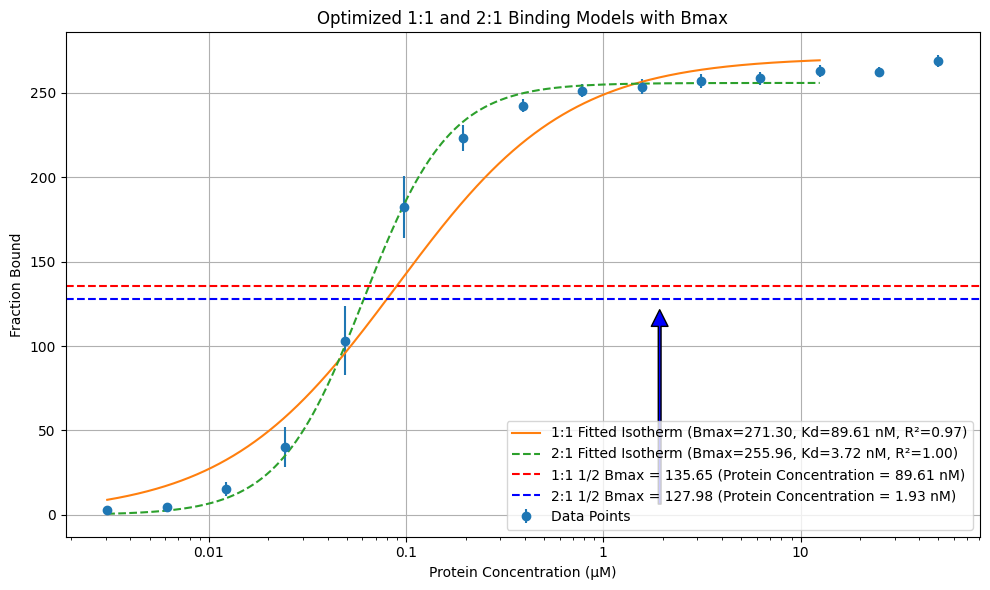

In [37]:
"""This does not work: the reported Kd values for the two-site model are wrong, and the arrow drawn does not show where the Kd is.

The following code was written predominantly by Copilot. The purpose of this code is to fit binding data to both 1:1 and 2:1 binding models and visualize the results. The code reads the provided binding data (concentration, values, and standard deviations) and fits the data points (excluding the first two data points) to the binding models. The fitting process is done using differential evolution for initial parameter estimation followed by curve fitting with `curve_fit`. The fitted isotherms for both models are plotted along with the data points. Additionally, arrows are drawn from the x-axis to the points where the half-maximal binding (1/2 Bmax) horizontal lines meet the binding isotherms, indicating the concentration corresponding to Kd for both models.

### Breakdown of the code:

1. **Imports and Data Preparation**:
    - `import os, numpy as np, pandas as pd, matplotlib.pyplot as plt`: Import necessary libraries for data handling, numerical operations, and plotting.
    - `from scipy.optimize import curve_fit, differential_evolution`: Import functions for optimization and curve fitting.
    - **Data Definition and Preprocessing**:
      - Data is provided in a dictionary format and converted into a DataFrame for easier manipulation.
      - Data points with zero or negative concentrations are removed.
    - **Protein Concentration and Fraction Bound**:
      - Protein concentrations, fraction bound values, and standard deviations are extracted from the DataFrame.

2. **Functions for Binding Models**:
    - **1:1 Binding Model**:
      ```python
      def calculate_fraction_bound_1to1(p, bmax, kd):
          kd = kd * 1e-3  # Convert Kd to µM for calculations
          return (bmax * p) / (kd + p)
      ```
      - Converts Kd to µM and calculates the fraction bound using a simple 1:1 binding model.
    - **2:1 Binding Model**:
      ```python
      def calculate_fraction_bound_2to1(p, bmax, kd):
          kd = kd * 1e-3  # Convert Kd to µM for calculations
          return (bmax * (p**2)) / (kd + (p**2))
      ```
      - Converts Kd to µM and calculates the fraction bound using a 2:1 binding model.

3. **Data Points to Fit**:
    - **Exclusion of First Two Data Points**:
      - The first two data points are excluded from the fitting process to focus on more reliable data points.
    - **Generate Denser Points**:
      - A denser set of protein concentration points is generated for smoother isotherms.

4. **Bounds and Objective Functions**:
    - **Bounds Definition**:
      - Bounds are defined for Bmax and Kd to avoid unrealistic values.
    - **Objective Functions**:
      - For 1:1 and 2:1 models, objective functions are defined to calculate residuals and optimize the fit using differential evolution.

5. **Initial Parameter Estimation**:
    - **Differential Evolution**:
      - Differential evolution is used for initial parameter estimation for both 1:1 and 2:1 models.

6. **Final Curve Fitting**:
    - **Curve Fitting with `curve_fit`**:
      - Final parameter fitting is performed using `curve_fit` with the optimized parameters from differential evolution.

7. **R² Calculation**:
    - **Calculate R² Values**:
      - The R² value is calculated for both models to measure the goodness of fit.

8. **Protein Concentration at 1/2 Bmax**:
    - **Calculate 1/2 Bmax**:
      - The concentration at half-maximal binding (1/2 Bmax) is calculated for both models.

9. **Plotting**:
    - **Plot Data Points**:
      - Data points are plotted with error bars.
    - **Plot Fitted Curves**:
      - Fitted isotherms for both models are plotted.
    - **Plot 1/2 Bmax Lines**:
      - Horizontal lines for 1/2 Bmax are plotted.
    - **Add Arrows**:
      - Arrows are added from the x-axis to the points where the half-maximal binding lines meet the binding isotherms.

"""



import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, differential_evolution

# Functions to calculate fraction bound for 1:1 and 2:1 binding models
def calculate_fraction_bound_1to1(p, bmax, kd):
    kd = kd * 1e-3  # Convert Kd to µM for calculations
    return (bmax * p) / (kd + p)

def calculate_fraction_bound_2to1(p, bmax, kd):
    kd = kd * 1e-3  # Convert Kd to µM for calculations
    return (bmax * (p**2)) / (kd + (p**2))

# Provided data
data = {
    'conc': [50, 25, 12.5, 6.25, 3.125, 1.5625, 0.78125, 0.390625, 0.195313, 0.097656, 0.048828, 0.024414, 0.012207, 0.006104, 0.00305, 0],
    'values': [269, 262.5, 263.08, 258.67, 256.92, 253.67, 251.45, 242.5, 223.58, 182.42, 103.33, 40.18, 15.33, 4.92, 2.92, 2.25],
    'stdev': [3.36, 2.88, 3.42, 3.89, 4.06, 4.52, 3.98, 3.99, 7.67, 18.35, 20.65, 11.86, 4.16, 1.78, 2.27, 1.42]
}

# Create DataFrame
df = pd.DataFrame(data)

# Extract data and remove any zero or negative values
df = df[df['conc'] > 0]
protein_concentration = df['conc'].values
fraction_bound = df['values'].values
stdev = df['stdev'].values

# Data points to fit (excluding the first two data points)
fit_protein_concentration = protein_concentration[2:]
fit_fraction_bound = fraction_bound[2:]
fit_stdev = stdev[2:]

# Generate a denser set of points for smooth isotherms
dense_protein_concentration = np.logspace(np.log10(min(fit_protein_concentration)), np.log10(max(fit_protein_concentration)), 1000)

# Define bounds for Bmax and Kd
bounds = [(0, max(fit_fraction_bound)), (0.01, max(fit_protein_concentration))]  # Added lower bound of 0.01 for kd to avoid unrealistic low values

# Objective functions for differential evolution optimization
def objective_function_1to1(params):
    bmax, kd = params
    fitted_values = calculate_fraction_bound_1to1(fit_protein_concentration, bmax, kd)
    residuals = (fit_fraction_bound - fitted_values) / fit_stdev
    return np.sum(residuals**2)

def objective_function_2to1(params):
    bmax, kd = params
    fitted_values = calculate_fraction_bound_2to1(fit_protein_concentration, bmax, kd)
    residuals = (fit_fraction_bound - fitted_values) / fit_stdev
    return np.sum(residuals**2)

# Use differential evolution for initial parameter estimation
result_1to1 = differential_evolution(objective_function_1to1, bounds)
result_2to1 = differential_evolution(objective_function_2to1, bounds)
bmax_opt_1to1, kd_opt_1to1 = result_1to1.x
bmax_opt_2to1, kd_opt_2to1 = result_2to1.x

# Perform the final fit using curve_fit with the optimized parameters
popt_1to1, _ = curve_fit(calculate_fraction_bound_1to1, fit_protein_concentration, fit_fraction_bound, sigma=fit_stdev, p0=[bmax_opt_1to1, kd_opt_1to1])
popt_2to1, _ = curve_fit(calculate_fraction_bound_2to1, fit_protein_concentration, fit_fraction_bound, sigma=fit_stdev, p0=[bmax_opt_2to1, kd_opt_2to1])
bmax_1to1, kd_1to1 = popt_1to1
bmax_2to1, kd_2to1 = popt_2to1

# Calculate R² values for each fit
def calculate_r_squared(observed, fitted):
    residuals = observed - fitted
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((observed - np.mean(observed))**2)
    return 1 - (ss_res / ss_tot)

fitted_values_1to1 = calculate_fraction_bound_1to1(fit_protein_concentration, *popt_1to1)
fitted_values_2to1 = calculate_fraction_bound_2to1(fit_protein_concentration, *popt_2to1)
r_squared_1to1 = calculate_r_squared(fit_fraction_bound, fitted_values_1to1)
r_squared_2to1 = calculate_r_squared(fit_fraction_bound, fitted_values_2to1)

# Calculate the protein concentration at half-maximal binding (1/2 Bmax) for both models
half_bmax_1to1 = bmax_1to1 / 2
half_bmax_2to1 = bmax_2to1 / 2
half_max_concentration_1to1 = kd_1to1  # For 1:1 binding, Kd is the concentration at 1/2 Bmax
half_max_concentration_2to1 = np.sqrt(kd_2to1)  # For 2:1 binding, sqrt(Kd) is the concentration at 1/2 Bmax

# Function for x-axis label formatting
def format_func(value, tick_number):
    return "{:.2g}".format(value)

# Generate plot
plt.figure(figsize=(10, 6))
plt.xscale('log')
plt.xlabel('Protein Concentration (µM)')
plt.ylabel('Fraction Bound')
plt.title('Optimized 1:1 and 2:1 Binding Models with Bmax')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_func))

# Plot data points
plt.errorbar(protein_concentration, fraction_bound, yerr=stdev, fmt='o', label='Data Points')
# Plot fitted curves
plt.plot(dense_protein_concentration, calculate_fraction_bound_1to1(dense_protein_concentration, *popt_1to1), '-', label=f'1:1 Fitted Isotherm (Bmax={bmax_1to1:.2f}, Kd={kd_1to1:.2f} nM, R²={r_squared_1to1:.2f})')
plt.plot(dense_protein_concentration, calculate_fraction_bound_2to1(dense_protein_concentration, *popt_2to1), '--', label=f'2:1 Fitted Isotherm (Bmax={bmax_2to1:.2f}, Kd={kd_2to1:.2f} nM, R²={r_squared_2to1:.2f})')

# Plot half Bmax lines
plt.axhline(half_bmax_1to1, color='r', linestyle='--', label=f'1:1 1/2 Bmax = {half_bmax_1to1:.2f} (Protein Concentration = {half_max_concentration_1to1:.2f} nM)')
plt.axhline(half_bmax_2to1, color='b', linestyle='--', label=f'2:1 1/2 Bmax = {half_bmax_2to1:.2f} (Protein Concentration = {half_max_concentration_2to1:.2f} nM)')

# Add arrows at the points where the half Bmax lines meet the binding isotherms
plt.annotate('', xy=(half_max_concentration_1to1, half_bmax_1to1), xytext=(half_max_concentration_1to1, 0), arrowprops=dict(facecolor='red', shrink=0.05, width=2))
plt.annotate('', xy=(half_max_concentration_2to1, half_bmax_2to1), xytext=(half_max_concentration_2to1, 0), arrowprops=dict(facecolor='blue', shrink=0.05, width=2))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
